In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import string
import re
import seaborn as sns
import plotly.express as px

from sklearn.metrics import confusion_matrix, roc_curve, auc
from string import punctuation
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Loading

In [5]:
#Load the contents of the file into the data variable
data = pd.read_excel('/content/drive/MyDrive/巴西/reviews_English.xlsx')

## Data preporcessing

#### Lowercase words and remove all punctuation

In [6]:
#Converts the column string to lowercase.And remove all punctuation marks, including those connected to words
data['review_comment_message'] = data['review_comment_message'].str.lower().str.replace('[{}]'.format(string.punctuation), '')

#### Rows with only spaces will appear in the column and need to be deleted

In [7]:
data = data[data['review_comment_message'].str.strip().astype(bool)]

In [8]:
data.isna().sum()

review_score               0
review_comment_message    28
dtype: int64

In [9]:
#New blank lines will be generated, so they need to be removed again.
data = data.dropna()

In [10]:
# Converts data['review_comment_message'] to a list that contains only characters
char_list = [str(c) for c in data['review_comment_message'] if isinstance(c, (str, float))]

# Then remove the punctuation marks
filtered_chars = [c for c in char_list if c not in punctuation]

# The filtered characters are concatenated into a string
all_text = ''.join(filtered_chars)

#### Split the string into a list of words

In [11]:
#Split the string into a list of words
data_split = [str(item) for item in data['review_comment_message'] if isinstance(item, (str, float))]

all_text = ' '.join(data_split)

words = all_text.split()

In [12]:
len(words)

548021

### Encoding the words

The words are converted into codes and matched into the original sentences, which are short, so there is no need to do too much length processing

In [13]:
#Process textual data and convert it to a sequence of integers
counts = Counter(words)
vocab = sorted(counts, key=counts.get, reverse=True)
vocab_to_int = {word: ii for ii, word in enumerate(vocab, 1)}

bbc_ints = []
for bbc in data_split:
    bbc_ints.append([vocab_to_int[word] for word in bbc.split()])

In [14]:
#Number of different words and the structure
print('Unique words: ', len((vocab_to_int)))
print()

print('Tokenized news: \n', bbc_ints[:1])

Unique words:  11433

Tokenized news: 
 [[2, 18, 4, 35, 41, 1, 236, 36]]


### Padding sequences

In order to handle text of different lengths, we use 0 for padding

In [15]:
#An eigenmatrix with a specified sequence length
def pad_features(reviews_ints, seq_length):
    ''' Return features of review_ints, where each review is padded with 0's
        or truncated to the input seq_length.
    '''

    # getting the correct rows x cols shape
    features = np.zeros((len(reviews_ints), seq_length), dtype=int)

    # for each review, I grab that review and
    for i, row in enumerate(reviews_ints):
        features[i, -len(row):] = np.array(row)[:seq_length]

    return features

In [16]:
# Test your implementation!

seq_length = 50
features = pad_features(bbc_ints, seq_length=seq_length)

## test statements - do not change - ##
assert len(features)==len(bbc_ints), "Your features should have as many rows as reviews."
assert len(features[0])==seq_length, "Each feature row should contain seq_length values."

# print first 30 values of the first 4 batches
print(features[:4,:30])

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0  325  425   16    1   90    1  404    9    1  425   11
  1601   26]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]]


In [17]:
features.shape

(41620, 50)

### Training, Validation,Test

In [18]:
data['review_score'] = (data['review_score'] > 2).astype(int)

In [19]:
#Specify a set partition ratio
result = data['review_score']

result = np.array(result)

split_frac = 0.8

## split data into training, validation, and test data (features and labels, x and y)

split_idx = int(len(features)*split_frac)
train_x, remaining_x = features[:split_idx], features[split_idx:]
train_y, remaining_y = result[:split_idx], result[split_idx:]

test_idx = int(len(remaining_x)*0.5)
val_x, test_x = remaining_x[:test_idx], remaining_x[test_idx:]
val_y, test_y = remaining_y[:test_idx], remaining_y[test_idx:]

## print out the shapes of your resultant feature data
print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape),
      "\nValidation set: \t{}".format(val_x.shape),
      "\nTest set: \t\t{}".format(test_x.shape))

			Feature Shapes:
Train set: 		(33296, 50) 
Validation set: 	(4162, 50) 
Test set: 		(4162, 50)


### DataLoaders and Batching

In [20]:
# create Tensor datasets
train_data = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
valid_data = TensorDataset(torch.from_numpy(val_x), torch.from_numpy(val_y))
test_data = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))

# dataloaders
batch_size = 200

# make sure the SHUFFLE your training data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=batch_size, drop_last=True)

In [21]:
# obtain one batch of training data
dataiter = iter(train_loader)
sample_x, sample_y = next(dataiter)

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([200, 50])
Sample input: 
 tensor([[  0,   0,   0,  ...,  73, 126,  21],
        [  0,   0,   0,  ...,   0,  10,  14],
        [  0,   0,   0,  ..., 135,   1,  36],
        ...,
        [  0,   0,   0,  ...,   0,   0, 206],
        [  0,   0,   0,  ...,  32,   9,  34],
        [  0,   0,   0,  ...,  59,  27,   3]])

Sample label size:  torch.Size([200])
Sample label: 
 tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1,
        0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
        1, 1, 1, 1, 1, 0, 1, 1, 0, 1,

### Sentiment Network with PyTorch

In [22]:
# First checking if GPU is available
train_on_gpu=torch.cuda.is_available()

if(train_on_gpu):
    print('Training on GPU.')
else:
    print('No GPU available, training on CPU.')

Training on GPU.


In [23]:
#RNN models for sentiment analysis
class SentimentRNN(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super(SentimentRNN, self).__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                            dropout=drop_prob, batch_first=True)

        # dropout layer
        self.dropout = nn.Dropout(0.25)#0.3

        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size,bias=True)#3
        self.sig = nn.Sigmoid()


    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        x = x.long()
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out[:, -1, :] # getting the last time step output

        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)

        # return last sigmoid output and hidden state
        return sig_out, hidden


    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data

        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())



        return hidden


## Instantiate the network

In [24]:
# Instantiate the model w/ hyperparams
vocab_size = len(vocab_to_int)+1 # +1 for the 0 padding + our word tokens
output_size = 1
embedding_dim = 400 #400
hidden_dim = 256
n_layers = 2

net = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers )

print(net)

SentimentRNN(
  (embedding): Embedding(11434, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


## Training

#### Set hyperparameters and define lr scheduler

In [25]:
# Elastic lr scheduler
lr=0.00001
patience = 100
weight_decay = 0.0001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=lr ,weight_decay=weight_decay)
scheduler = ReduceLROnPlateau(optimizer, mode = 'min', factor=0.001 ,patience=patience//2 ,verbose=True)

In [26]:
# training params

epochs = 1000
counter = 0
print_every = 100
clip=5 # gradient clipping

#
best_val_loss = 0
no_improvement_epochs = 0
# patience = 10
loss_storage = []
val_losses_storage = []
lr_storage = []

# move model to GPU, if available
if(train_on_gpu):
    net.cuda()

net.train()
# train for some number of epochs
for e in range(epochs):
    # initialize hidden state
    h = net.init_hidden(batch_size)
    val_losses = []#新加的

    # batch loop
    for inputs, labels in train_loader:
        counter += 1

        if(train_on_gpu):
            inputs, labels = inputs.cuda(), labels.cuda()

        # Creating new variables for the hidden state, otherwise
        # we'd backprop through the entire training history
        h = tuple([each.data for each in h])

        # zero accumulated gradients
        net.zero_grad()

        # get the output from the model
        output, h = net(inputs, h)

        # calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(net.parameters(), clip)
        optimizer.step()

        # loss stats
        if counter % print_every == 0:
            # Get validation loss
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            for inputs, labels in valid_loader:

                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                val_h = tuple([each.data for each in val_h])

                if(train_on_gpu):
                    inputs, labels = inputs.cuda(), labels.cuda()

                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())

                val_losses.append(val_loss.item())

            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            loss_storage.append(loss.item())#新標記
            val_losses_storage.append(np.mean(val_losses))
    #——————————————————————————————————————————————lr scheduler
    val_loss = np.mean(val_losses)
    scheduler.step(val_loss)
    lr_storage.append(optimizer.param_groups[0]['lr'])
    #——————————————————————————————————————————————early stopping
    # Calculate average validation loss for this epoch for early stopping
    # Check if validation loss decreased
    if np.mean(val_losses) < best_val_loss:
        # Update best validation loss and save model weights
        best_val_loss = np.mean(val_losses)
        torch.save(net.state_dict(), 'best_model.pth')
        no_improvement_epochs = 0  # Reset the counter for no improvement epochs
    else:
        no_improvement_epochs += 1

    # Check if patience has been exceeded
    if no_improvement_epochs >= patience:
        print("No improvement in validation loss for {} epochs. Early stopping.".format(patience))
        break
    # ... (your existing code for printing progress)

Epoch: 1/1000... Step: 100... Loss: 0.643633... Val Loss: 0.626239
Epoch: 2/1000... Step: 200... Loss: 0.546983... Val Loss: 0.525512
Epoch: 2/1000... Step: 300... Loss: 0.496272... Val Loss: 0.504327
Epoch: 3/1000... Step: 400... Loss: 0.509209... Val Loss: 0.490747
Epoch: 4/1000... Step: 500... Loss: 0.484272... Val Loss: 0.460733
Epoch: 4/1000... Step: 600... Loss: 0.422893... Val Loss: 0.427146
Epoch: 5/1000... Step: 700... Loss: 0.345145... Val Loss: 0.403116
Epoch: 5/1000... Step: 800... Loss: 0.392256... Val Loss: 0.378336
Epoch: 6/1000... Step: 900... Loss: 0.309756... Val Loss: 0.364549
Epoch: 7/1000... Step: 1000... Loss: 0.366408... Val Loss: 0.349825
Epoch: 7/1000... Step: 1100... Loss: 0.328027... Val Loss: 0.343731
Epoch: 8/1000... Step: 1200... Loss: 0.278366... Val Loss: 0.339588
Epoch: 8/1000... Step: 1300... Loss: 0.289142... Val Loss: 0.326875
Epoch: 9/1000... Step: 1400... Loss: 0.317678... Val Loss: 0.325756
Epoch: 10/1000... Step: 1500... Loss: 0.287316... Val Los

#### Loss chart

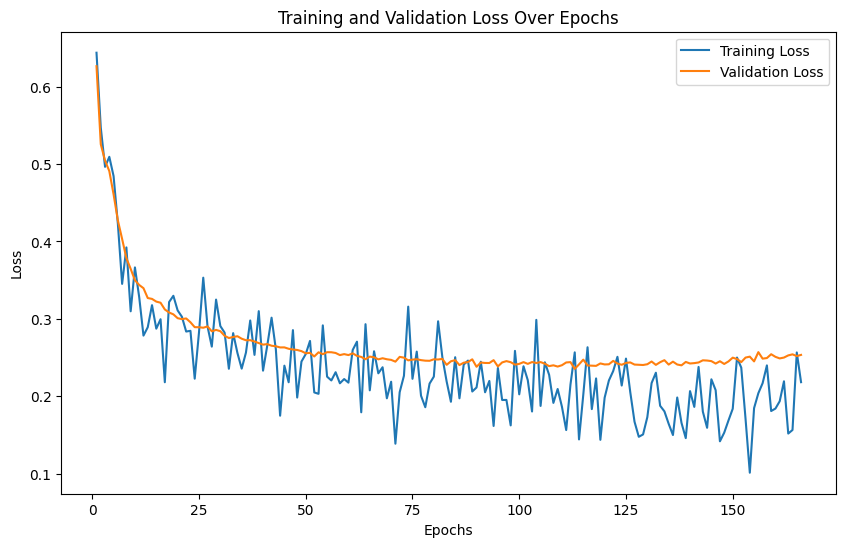

In [86]:
# Get the number of epochs
epochs = len(loss_storage)
# Create a new chart
plt.figure(figsize=(10, 6))
# Plot the training loss curve
plt.plot(range(1, epochs + 1), loss_storage, label='Training Loss')
# Draw a verification loss curve
plt.plot(range(1, epochs + 1), val_losses_storage, label='Validation Loss')
# Set the chart title and label
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display legend
plt.legend()

# Display graphics
plt.show()

## ROC curve

#### Get the latest model prediction results in the validation set

In [102]:
all_val_outputs = []
all_val_labels = []
net.eval()  # Switch the model to evaluation mode and turn off the training mode behavior of dropout and batch normalization.
with torch.no_grad():  # Turn off automatic derivation to improve calculation efficiency
    for inputs, labels in valid_loader:
        if train_on_gpu:
            inputs, labels = inputs.cuda(), labels.cuda()

        val_h = net.init_hidden(batch_size)
        val_h = tuple([each.data for each in val_h])

        output, _ = net(inputs, val_h)
        output = torch.sigmoid(output.squeeze())  # For binary classification problems, apply the sigmoid function to obtain the probability

        # Accumulate the output of all batches
        all_val_outputs.extend(output.cpu().numpy())
        all_val_labels.extend(labels.cpu().numpy())

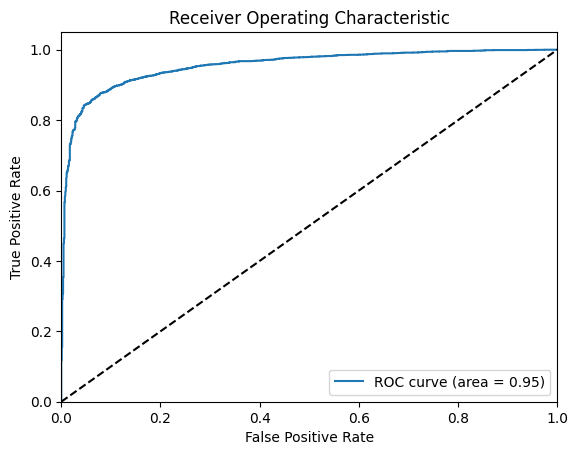

In [103]:
fpr, tpr, thresholds = roc_curve(all_val_labels, all_val_outputs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Testing

In [28]:
# Get test data loss and accuracy

test_losses = [] # track loss
num_correct = 0

# init hidden state
h = net.init_hidden(batch_size)

net.eval()
# iterate over test data
for inputs, labels in test_loader:

    # Creating new variables for the hidden state, otherwise
    # we'd backprop through the entire training history
    h = tuple([each.data for each in h])

    if(train_on_gpu):
        inputs, labels = inputs.cuda(), labels.cuda()

    # get predicted outputs
    output, h = net(inputs, h)

    # calculate loss
    test_loss = criterion(output.squeeze(), labels.float())
    test_losses.append(test_loss.item())

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())  # rounds to the nearest integer

    # compare predictions to true label
    correct_tensor = pred.eq(labels.float().view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    num_correct += np.sum(correct)


# -- stats! -- ##
# avg test loss
print("Test loss: {:.3f}".format(np.mean(test_losses)))

# accuracy over all test data
test_acc = num_correct/len(test_loader.dataset)
print("Test accuracy: {:.3f}".format(test_acc))

Test loss: 0.250
Test accuracy: 0.860


### Inference on a test review

In [29]:
# negative test review
test_review_neg = 'So bad, left me with only bad effects, will not come again.'


In [30]:
from string import punctuation

def tokenize_review(test_review):
    test_review = test_review.lower() # lowercase
    # get rid of punctuation
    test_text = ''.join([c for c in test_review if c not in punctuation])

    # splitting by spaces
    test_words = test_text.split()

    # tokens
    test_ints = []
    test_ints.append([vocab_to_int.get(word, 0) for word in test_words])

    return test_ints

# test code and generate tokenized review
test_ints = tokenize_review(test_review_neg)
print(test_ints)

[[69, 217, 299, 54, 25, 37, 217, 3306, 79, 15, 177, 196]]


In [31]:
# test conversion to tensor and pass into your model
feature_tensor = torch.from_numpy(features)
print(feature_tensor.size())

torch.Size([41620, 50])


In [32]:
#Only predictions with confidence and judgment are returned
def predict(net, test_review, sequence_length=200):

    net.eval()

    # tokenize review
    test_ints = tokenize_review(test_review)

    # pad tokenized sequence
    seq_length=sequence_length
    features = pad_features(test_ints, seq_length)

    # convert to tensor to pass into your model
    feature_tensor = torch.from_numpy(features)

    batch_size = feature_tensor.size(0)

    # initialize hidden state
    h = net.init_hidden(batch_size)

    if(train_on_gpu):
        feature_tensor = feature_tensor.cuda()

    # get the output from the model
    output, h = net(feature_tensor, h)

    # convert output probabilities to predicted class (0 or 1)
    pred = torch.round(output.squeeze())
    # printing output value, before rounding

    #In the following steps, you need to selectively block print to reduce output content.
    # print('Prediction value, pre-rounding: {:.6f}'.format(output.item()))


    # print custom response

    # if(pred.item()==1):
    #     print("Positive reviews detected!")
    # else:
    #     print("Negative reviews detected.")

    return output.item() ,pred.item()

In [33]:
# positive test reviews
test_review_pos = 'Very good personal service, I was very impressed. It will come again next time.'

In [34]:
# call function
seq_length=30 # good to use the length that was trained on

predict(net, test_review_neg, seq_length)

(0.05332981422543526, 0.0)

In [35]:
# call function
seq_length=30 # good to use the length that was trained on

predict(net, test_review_pos, seq_length)

(0.9924039244651794, 1.0)

## Try to find negative words in comments

In [36]:
new_tab = pd.DataFrame.from_dict(counts,orient='index',columns=['Frequency'])
new_tab['words'] = new_tab.index
new_tab = new_tab[['words','Frequency']]
new_tab.head(5)

,words,Frequency
i,i,29723
received,received,5225
it,it,18226
well,well,2602
before,before,2341


#### Remove lines with only punctuation characters

In [37]:
def is_only_punctuation(word):
  return all(char in string.punctuation for char in word)
new_tab['is_only_punctuation'] = new_tab['words'].apply(is_only_punctuation)
new_tab = new_tab[~new_tab['is_only_punctuation']]
new_tab = new_tab.drop('is_only_punctuation',axis=1)

#### Put each word into the model to get the score and sentiment

In [38]:
tem_storage = {}
for i in new_tab['words']:
  k = predict(net, i, seq_length)
  tem_storage[i]=k

In [39]:
word_dic = pd.DataFrame.from_dict(tem_storage,orient='index',columns=['prediction','sentiment'])
word_dic['words'] = word_dic.index
word_dic = word_dic[['words','prediction','sentiment']]
word_dic.head(5)

,words,prediction,sentiment
i,i,0.960329,1.0
received,received,0.883630,1.0
it,it,0.904184,1.0
well,well,0.966638,1.0
before,before,0.956696,1.0


In [40]:
word_dic = pd.merge(word_dic,new_tab,on='words')
word_dic.head(5)

,words,prediction,sentiment,Frequency
0,i,0.960329,1.0,29723
1,received,0.883630,1.0,5225
2,it,0.904184,1.0,18226
3,well,0.966638,1.0,2602
4,before,0.956696,1.0,2341


#### Select words that appear more frequently for analysis

In [41]:
word_dic[word_dic['Frequency']>6].sort_values('prediction').head(15)

,words,prediction,sentiment,Frequency
63,terrible,0.163493,0.0,271
504,bad,0.372837,0.0,306
90,not,0.388234,0.0,5774
298,broken,0.407361,0.0,288
330,delay,0.475630,0.0,403
313,dont,0.476178,0.0,948
536,defective,0.508880,1.0,284
573,poor,0.513540,1.0,264
409,didnt,0.554538,1.0,2284
123,never,0.568222,1.0,418


#### Scatter plot of frequency and rating

In [42]:
fig = px.scatter(word_dic[word_dic['Frequency']>10], x='prediction', y='Frequency',
                 symbol= 'words',
                 width = 1000, height= 500 )
fig.show()